# Preprocessing training data

This is the continuation of my previous article. In this article, I will apply a preprocessing method on the dataset that was presented in the previous article (*Keras1.ipynb*), followed by the training of the deep learning networks. At the end, testing results will be presented.

It should be noted that the dataset that was presented in the previous article had uneven distribution of true and false cases. In particular, the dataset had 268 true cases and 500 false cases of diabetese. Details on the dataset can be found in the following link: 
https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names

The deep learning model trained using such dataset can lead to the biasness in the trained network outcome because more true cases are fed to the network than false cases. Such issues has been discussed in the following article by Satya Mallick:

https://www.learnopencv.com/bias-variance-tradeoff-in-machine-learning/

To avoid it, the dataset should have equal numbers of true and false cases, respectively. Therefore let us create new data that has the property. Furthermore, the training and testing of the model should be done in different sets. Therefore, the data set will be divided into 4 such sets, and one set will be used to train, whereas the remainings are used for testing the model.

The preprocessing steps can be explained by the following figure
![alt text](preprocessingProcess.png)

In [0]:
!pip install --upgrade -q gspread

from google.colab import auth
auth.authenticate_user()


import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('pima-indians-diabetes').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()



# Convert to a DataFrame and render.
import pandas as pd
import numpy  as np
dataset =pd.DataFrame.from_records(rows)

#Converting to numpy arrays for X and Y
WholeData=dataset.values[:,:] 
true_case =np.empty([1,9])
false_case =np.empty([1,9])

#creating two dataset for true and false case
for row in WholeData:
   if(row[8]=='1'):
    true_case= np.vstack((true_case,row))
   else:
    false_case= np.vstack((false_case,row))
    
#deleting the first row as it contains garbage due to empty
false_case = false_case[1:-1,:] 
true_case =true_case[1:-1,:]

#creating 4 different sets from true_case and false case
dataSet =[]
for i in range(4):
  temp_set = np.empty([1,9])
  for j in range(66):
    temp_set = np.vstack((temp_set,true_case[i*67+j,:]))
    temp_set = np.vstack((temp_set,false_case[i*67+j,:]))
  temp_set = temp_set[1:-1,:]
  dataSet.append(temp_set)



Now let us initialize 2 neural networks as in the previous case. 

In [2]:
from keras.models import Sequential
from keras.layers import Dense

#Initializing Keras model 1
model1 = Sequential()
model1.add(Dense(12, input_dim=8, activation='relu',kernel_initializer='random_uniform'))
model1.add(Dense(8, activation='relu',kernel_initializer='random_uniform'))
model1.add(Dense(1, activation='sigmoid',kernel_initializer='random_uniform'))

# Compile model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.save_weights('model1.h5')

#Initializing Keras model 2
model2 = Sequential()
model2.add(Dense(8, input_dim=8, activation='relu',kernel_initializer='random_uniform'))
model2.add(Dense(12, activation='relu',kernel_initializer='random_uniform'))
model2.add(Dense(1, activation='sigmoid',kernel_initializer='random_uniform'))

# Compile model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.save_weights('model2.h5')



Using TensorFlow backend.


Now let us train and test the models

In [46]:
model1Acc = np.zeros([4,4])
model2Acc = np.zeros([4,4])

for i in range(4):
  X_train = dataSet[i][:,0:8]
  Y_train = dataSet[i][:,8]
  model1.load_weights('model1.h5')
  model2.load_weights('model2.h5')
  model1.fit(X_train,Y_train, epochs=500, batch_size=10,verbose=0)
  model2.fit(X_train,Y_train, epochs=500, batch_size=10,verbose=0)
  for j in range(4):
    X = dataSet[j][:,0:8]
    Y = dataSet[j][:,8]
       
      
    tempScore = model1.evaluate(X,Y)
    model1Acc[i,j]=tempScore[1]
    tempScore = model2.evaluate(X,Y)
    model2Acc[i,j]=tempScore[1]
print(model1Acc)
print(model2Acc)



131/131 [==============================] - 0s 48us/step
[[0.81679389 0.67175573 0.64122137 0.73282443]
 [0.58778626 0.79389313 0.64885496 0.70229008]
 [0.63358779 0.65648855 0.86259542 0.65648855]
 [0.65648855 0.67175573 0.66412214 0.83969466]]
[[0.76335878 0.70992366 0.65648855 0.83206107]
 [0.6259542  0.83206107 0.65648855 0.72519084]
 [0.63358779 0.64885496 0.80152672 0.64122137]
 [0.69465649 0.67938931 0.69465649 0.85496183]]


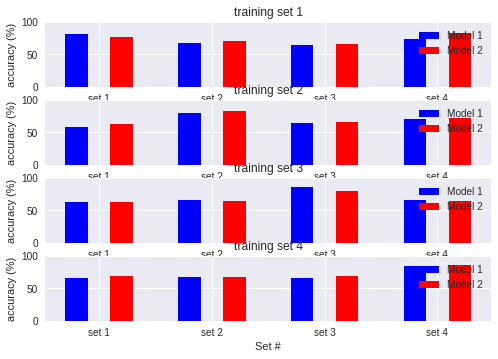

In [47]:
#let us start plotting
import matplotlib.pyplot as plt

width =1/5
X = np.asarray([0, 1, 2, 3])
setNo = ['set 1','set 2', 'set 3', 'set 4']
pos = np.arange(len(setNo))
for i in range(4):
  plt.subplot(4,1,i+1)
  plot_title = 'training set '+str(i+1)
  plt.bar(X-0.2,np.multiply(model1Acc[i,:],100),width,color="blue", align ='center')
  plt.bar(X+0.2,np.multiply(model2Acc[i,:],100),width,color="red", align ='center')
  plt.xlabel('Set #')
  plt.xticks(pos,setNo)
  plt.ylabel('accuracy (%)')
  plt.ylim(0,100)
  plt.legend(['Model 1','Model 2'], loc=1)
  plt.title(plot_title)